In [708]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def conditional_sampling(mean, cov, nsamples, nconds):
    k = len(mean) // 2
    c11 = cov[0:k, 0:k]  # Covariance matrix of the dependent variables
    c12 = cov[0:k, k:len(cov)]  # Custom array only containing covariances, not variances
    c21 = cov[k:len(cov), 0:k]
    c22 = cov[k:len(cov), k:len(cov)] # Covariance matrix of independent variables

    m1 = mean[0:k].T # Mu of dependent variables
    m2 = mean[k:len(cov)].T # Mu of independent variables
    
    xs = np.random.multivariate_normal(m2, c22, nsamples) # independent data
    xs = np.repeat(xs, nconds, axis=0)
    x_probs = multivariate_normal(m2, c22).logpdf(xs)

    conditional_mu = m1 + c12.dot(np.linalg.inv(c22)).dot((xs - m2).T).T
    conditional_cov = np.linalg.inv(np.linalg.inv(cov)[0:k, 0:k])

    # y_cond_xs = np.array([np.random.multivariate_normal(c_mu, conditional_cov, 1)[0] for c_mu in conditional_mu])
    y_cond_xs = np.random.uniform(low=np.diag(-c11)+m1, high=np.diag(c11)+m1, size=xs.shape)
    y_probs = multivariate_normal(m1, c11).logpdf(y_cond_xs)
    
    x_y_cond_xs = np.concatenate((y_cond_xs, xs), axis=1)
    xy_probs = multivariate_normal(mean, cov).logpdf(x_y_cond_xs)
    
    ycondx_probs = xy_probs - x_probs # log scaled
    xcondy_probs = xy_probs - y_probs
    
    return xs, y_cond_xs, (x_probs, y_probs, ycondx_probs, xcondy_probs, xy_probs)
    
ndim = 2    
mean, cov = np.zeros(2), np.array([[1, 0.7], [0.7, 1]])
xs, y_cond_xs, (x_probs, y_probs, ycondx_probs, xcondy_probs, xy_probs) = conditional_sampling(mean, cov, 10000, 1000)
print(np.cov(xs.T, y_cond_xs.T))

[[ 1.00634138e+00 -1.22291165e-04]
 [-1.22291165e-04  3.33237968e-01]]


In [788]:
from scipy.stats import pearsonr
from copy import deepcopy

def get_sample_tradeoff_df(ndim, mean, cov, nsamples, nconds):
    
    def get_n_correlation(df, n, lo_quantile=0.9, hi_quantile=1.0):
        if len(df) < n:
            return np.nan
        # asc = False if top else True
        y_labels = [f'y{i}' for i in range(ndim)]
        df = df.drop_duplicates(y_labels)
        lo_pycondx_q = df['p_y_cond_x'].quantile(lo_quantile)
        hi_pycondx_q = df['p_y_cond_x'].quantile(hi_quantile)
        df = df[(df['p_y_cond_x'] >= lo_pycondx_q) & (df['p_y_cond_x'] < hi_pycondx_q)]
        # df = df.sort_values('p_y_cond_x', ascending=asc).head(n)
        return pearsonr(df['p_y'], df['p_x_cond_y']).statistic
    
    xs, y_cond_xs, (x_lprobs, y_lprobs, ycondx_lprobs, xcondy_lprobs, xy_lprobs) = conditional_sampling(mean, cov, nsamples, nconds)
    # sim_df = pd.DataFrame({'x': np.round(xs.flatten(), 6), 'y': np.round( y_cond_xs.flatten(), 6), 'p_x': x_lprobs, 'p_y': y_lprobs, 
    #                        'p_xy': xy_lprobs, 'p_x_cond_y': xcondy_lprobs, 'p_y_cond_x': ycondx_lprobs})
    
    sim_df = pd.DataFrame({'p_x': x_lprobs, 'p_y': y_lprobs, 'p_xy': xy_lprobs, 'p_x_cond_y': xcondy_lprobs, 'p_y_cond_x': ycondx_lprobs})
    
    for i in range(ndim):
        sim_df[f'x{i}'] = xs[:, i]
        sim_df[f'y{i}'] = y_cond_xs[:, i]
        
    x_labels = [f'x{i}' for i in range(ndim)]
    
    sim_agg_df = sim_df.groupby(x_labels).apply(lambda x: get_n_correlation(x, 20, lo_quantile=0, hi_quantile=1)).reset_index().rename(columns={0: 'all_n_corr'})
    
    for i, fiftieth in enumerate(np.arange(0, 1, 0.1)):
        sim_top_corr_df = sim_df.groupby(x_labels).apply(lambda x: get_n_correlation(
            x, 20, lo_quantile=fiftieth, hi_quantile=fiftieth+0.1)).reset_index().rename(columns={0: f'{i}_.1_corr'})
    
        sim_agg_df = sim_agg_df.merge(sim_top_corr_df, on=x_labels, how='inner')
    
    sim_df = sim_df.merge(sim_agg_df, on=x_labels, how='left')
    return sim_df, sim_agg_df


def plot_y_probs(x_quantile, ndim, sim_df, ax, exp=False):
    x_labels = [f'x{i}' for i in range(ndim)]
    new_df = deepcopy(sim_df)

    df = sim_df[sim_df['p_x'] == sim_df['p_x'].quantile(x_quantile, interpolation='nearest')]

    if exp:
        im = ax.hexbin(np.exp(df['p_x_cond_y']), np.exp(df['p_y']), C=np.exp(df['p_y_cond_x']), gridsize=20, mincnt=0)
    else:
        im = ax.hexbin(df['p_x_cond_y'],df['p_y'], C=df['p_y_cond_x'], gridsize=20, mincnt=0)
    ax.set_ylabel(r'$p(y)$', size=13)
    ax.set_xlabel(r'$p(x|y)$', size=13)
    cbar = plt.colorbar(im)
    cbar.set_label(r'$p(y|x)$', rotation=270)
    return ax, cbar, df['p_x'].values[0]
    
    

In [711]:
def get_cov_mean(ndim, covariance):
    # init_mtx = np.random.uniform(low=0.8, high=0.9, size=(ndim*2, ndim*2))
    init_mtx = np.ones((ndim*2, ndim*2)) * covariance
    np.fill_diagonal(init_mtx, 1)
    cov = np.dot(init_mtx.T, init_mtx)
    mean = np.zeros(ndim*2)
    
    return cov, mean

In [820]:
ndims = [1,2,4,8]
ndim_cov = {1: np.array([[1, 0.8], [0.8, 1]]), 
            2: np.array([[ 1.0,  0.8,  0.5, 0.1], [ 0.8,  1.0,  0.1, 0.2], [ 0.5,  0.1,  1.0, 0.3], [0.1, 0.2, 0.3,  1.0]])}
sim_dfs, sim_agg_dfs = {ndim: {} for ndim in ndims}, {ndim: {} for ndim in ndims}

for covar in [0.6, 0.7, 0.8]:
    for ndim in ndims:
        cov, mean = get_cov_mean(ndim, covar) 
        sim_dfs[ndim][covar], sim_agg_dfs[ndim][covar] = get_sample_tradeoff_df(ndim, mean, cov, 100, 10000)
    

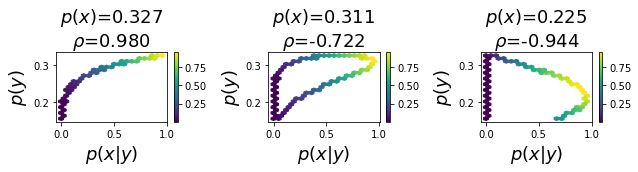

In [833]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.5))
x_quantiles = [1, 0.8,  0.4]
covar = 0.7

for i, ndim in enumerate([1]):
    sim_df = sim_dfs[ndim][covar]
    for j, x_quantile in enumerate(x_quantiles):
        ax = axes[j]
        ax, cbar, px = plot_y_probs(x_quantile, ndim, sim_df, ax, exp=True)
        
        top_corr = sim_df[sim_df['p_x'] == px]['9_.1_corr'].values[0]
        ax.set_xlabel(r'$p(x|y)$', size=18)
        # ax.set_ylabel(r'$\log p(y)$')
        if j == 0:
            ax.set_ylabel(r'$p(y)$', size=18)
        else:
            ax.set_ylabel(r'$p(y)$', size=18)
        ax.set_title(r'$p(x)$=' + f'{np.exp(px):.03f}\n' + r'$\rho$=' + f'{top_corr:.3f}', size=18)
        cbar.set_label(None)
        
plt.tight_layout()
plt.savefig('figures/simulation_px_dim.pdf', bbox_inches='tight', dpi=1200, format='pdf')

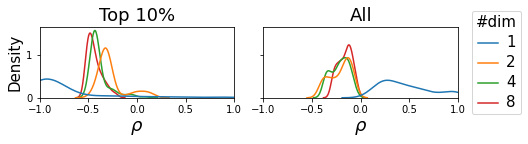

In [835]:
import seaborn as sns

for i in ndims:
    sim_agg_dfs[i][covar]['#dim'] = i
    # sim_agg_dfs[2]['#dim'] = 2
agg_df = pd.concat([sim_agg_dfs[i][covar] for i in [1,2,4,8]])


fig, axes = plt.subplots(1, 2, figsize=(7.5, 1.3),  gridspec_kw={ 'wspace':0.15}, sharey=True)

sns.kdeplot(
   data=agg_df, x='9_.1_corr', hue="#dim",  palette=sns.color_palette()[:4], ax=axes[0]).set(xlim=(-1, 1))
axes[0].set_title('Top 10%', size=18)
axes[0].set_xlabel(r'$\rho$', size=18)
axes[0].set_ylabel('Density', size=15)

sns.kdeplot(
   data=agg_df, x="all_n_corr", hue="#dim", multiple='layer', palette=sns.color_palette()[:4], ax=axes[1],
).set(xlim=(-1, 1))

axes[1].set_title('All', size=18)
axes[1].set_xlabel(r'$\rho$', size=18)

plt.setp(axes[0].get_legend().get_title(), fontsize='15') # for legend title
plt.setp(axes[0].get_legend().get_texts(), fontsize='15')
axes[0].get_legend().set_bbox_to_anchor((2.5,  1.3))
axes[1].get_legend().remove()
axes[1].set_ylabel('Density', size=15)
plt.savefig('figures/tradeoff_reduced_with_dim.pdf', bbox_inches='tight', dpi=1200, format='pdf')